# Importing Necessary Libraries

In [170]:
# Data Analysis
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Machine Learning
from sklearn.metrics import mean_squared_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Loading and Understanding

In [171]:
# Loading train data
train_df = pd.read_csv('Train_SU63ISt.csv')
print(f'Shape of train data: {train_df.shape}')
train_df.head()

Shape of train data: (18288, 3)


,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [172]:
# Loading test data
test_df = pd.read_csv('Test_0qrQsBZ.csv')
print(f'Shape of test data: {test_df.shape}')
test_df.head()

Shape of test data: (5112, 2)


,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [173]:
# Inspecting the datasets
train_df.info()
print('-'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        5112 non-null   int64 
 1   Datetime  5112 non-null   object
dtypes: int64(1), object(1)
memory usage: 80.0+ KB


There are no missing values in both train and test datasets.

In [174]:
# Duplicates Check
train_df.duplicated().sum()

0

There are no duplicate values in train data.

In [175]:
# Preparing data for forecasting
train_df_pr = train_df.copy()

# Converting data type of 'Datetime' column from object to datetime
train_df_pr['Datetime'] = pd.to_datetime(train_df_pr['Datetime'], format='%d-%m-%Y %H:%M')

# Using 'Datetime' column as Index and dropping 'ID' column
train_df_pr.sort_values('Datetime', inplace=True)
train_df_pr.set_index('Datetime', inplace=True)
train_df_pr.drop(columns='ID', inplace=True)

train_df_pr.head()

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


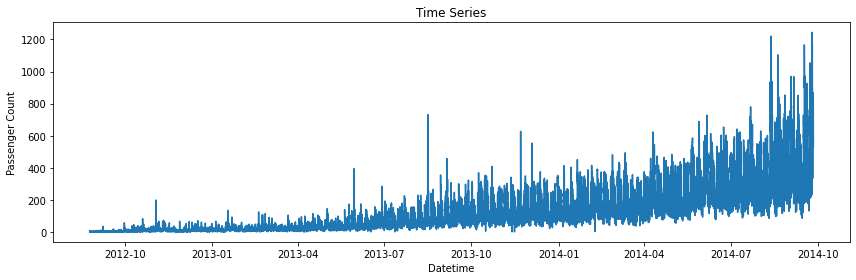

In [176]:
# Plotting the time series
plt.figure(figsize=(12, 4))
plt.plot(train_df_pr)
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.title('Time Series')
plt.tight_layout()
plt.show()

As we can see, there is a lot of noise in the hourly time series. So let us aggregate hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

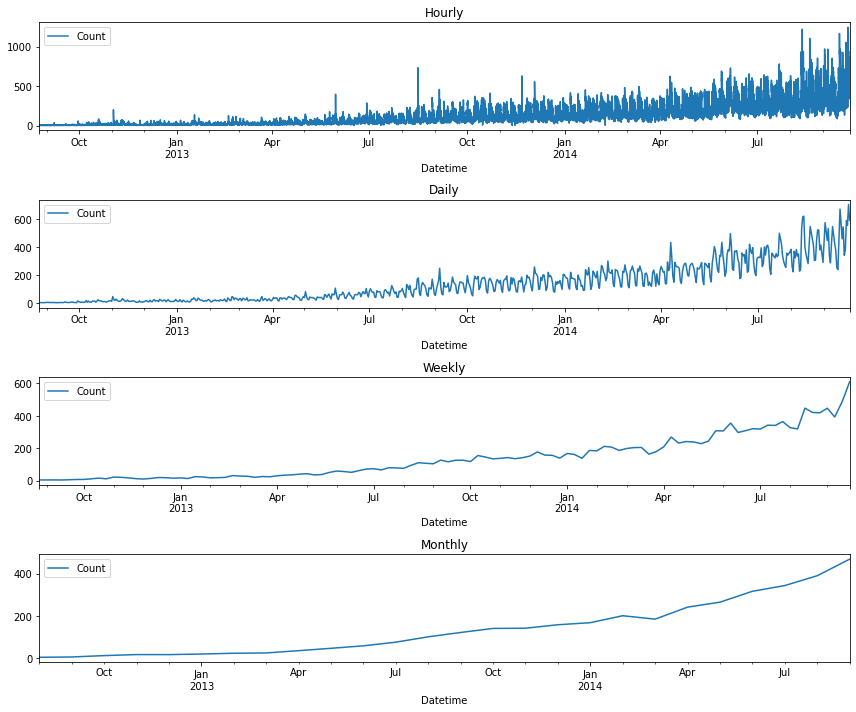

In [177]:
# Aggregating our hourly time series to daily, weekly, and monthly basis
hourly = train_df_pr.resample('H').mean()
daily = train_df_pr.resample('D').mean()
weekly = train_df_pr.resample('W').mean()
monthly = train_df_pr.resample('M').mean()

# Plotting the same
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
hourly.plot(title='Hourly', ax=axes[0])
daily.plot(title='Daily', ax=axes[1])
weekly.plot(title='Weekly', ax=axes[2])
monthly.plot(title='Monthly', ax=axes[3])
plt.tight_layout()
plt.show()

We can observe from above plots, time series is getting more stable as we move from hourly to monthly time series. But, if we consider weekly or monthly time series, it will become difficult to convert back the predictions to hourly basis. Therefore, let us proceed further with the daily time series.

In [178]:
# Understanding the data for time based train-test split
print(f'Start Date: {daily.index.min()}')
print(f'End Date: {daily.index.max()}')
print(f'Total Days: {len(daily)}')

Start Date: 2012-08-25 00:00:00
End Date: 2014-09-25 00:00:00
Total Days: 762


There are total 25 months. Let us divide our daily time series into training and validation set with validation set comprising of last 3 months.

Shape: Train=(669, 1), Validation=(93, 1)


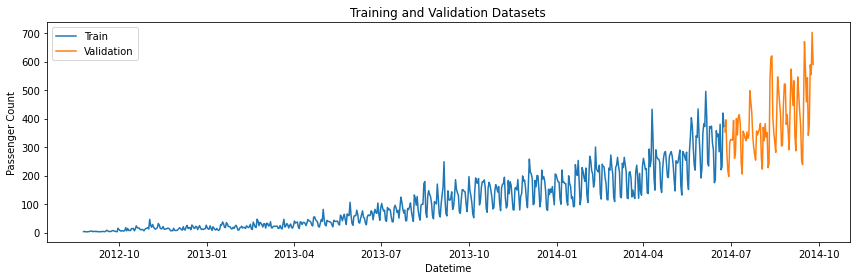

In [179]:
# Time based train-test splitting
train = daily.loc[:'2014-06-24']
valid = daily.loc['2014-06-25':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Validation')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

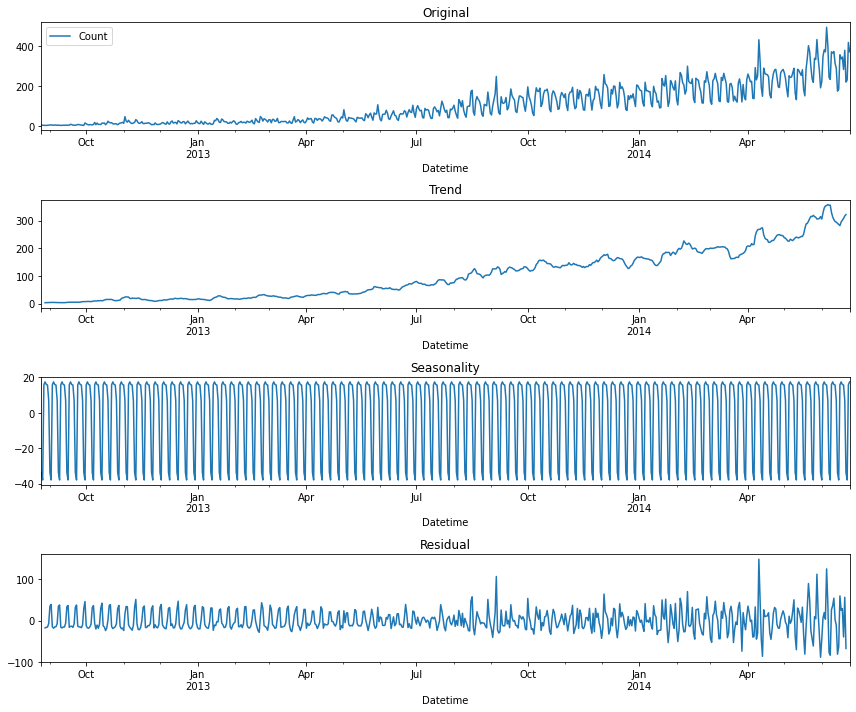

In [180]:
# Visualizing the components of our time series: Trend, Seasonality, and Noise
decomposition = sm.tsa.seasonal_decompose(train)

# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

Data can be seen to have an upward trend.

# Simple Exponential Smoothing
Let us now create a baseline model, whose performance will serve as a benchmark for the subsequent models. Simple exponential smoothing takes weighted average of the past data such that highest weightage is given to the latest data and lowest to the oldest data.

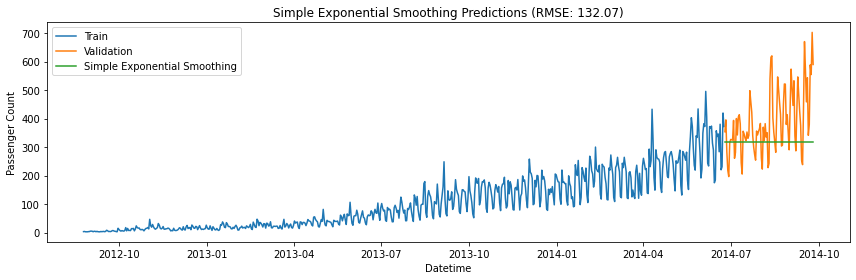

In [181]:
# Applying Simple Exponential Smoothing
ses = SimpleExpSmoothing(train).fit()
ses_pred = ses.forecast(len(valid))
ses_rmse = mean_squared_error(valid, ses_pred, squared=False)

# Plotting the predictions
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Validation')
plt.plot(ses_pred, label='Simple Exponential Smoothing')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.title(f'Simple Exponential Smoothing Predictions (RMSE: {round(ses_rmse, 2)})')
plt.legend()
plt.tight_layout()
plt.show()

# Holt's Linear Trend Model
Holt's linear trend model takes into account the trend of the data unlike simple exponential smoothing model.

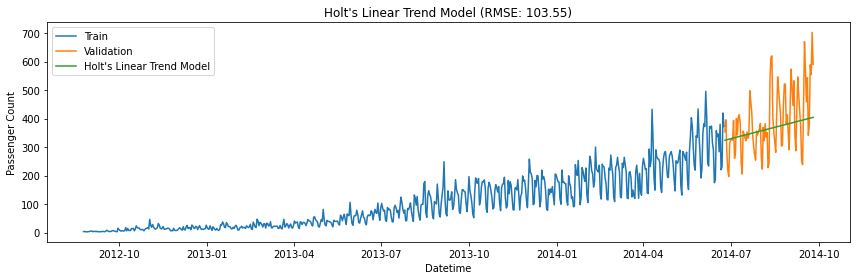

In [182]:
# Applying Holt's Linear Trend Model
hltm = Holt(train).fit()
hltm_pred = hltm.forecast(len(valid))
hltm_rmse = mean_squared_error(valid, hltm_pred, squared=False)

# Plotting the predictions
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Validation')
plt.plot(hltm_pred, label='Holt\'s Linear Trend Model')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.title(f'Holt\'s Linear Trend Model (RMSE: {round(hltm_rmse, 2)})')
plt.legend()
plt.tight_layout()
plt.show()

# Holt Winter's Model
Holt Winter's model takes into account both trend and seasonality unlike Holt's linear trend model and simple exponential smoothing model.

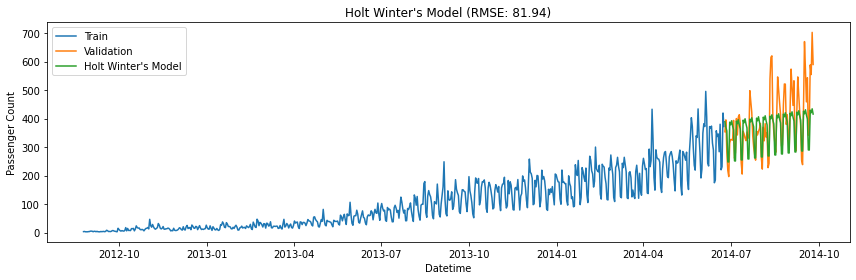

In [183]:
# Applying Holt Winter's Model
hwm = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add').fit()
hwm_pred = hwm.forecast(len(valid))
hwm_rmse = mean_squared_error(valid, hwm_pred, squared=False)

# Plotting the predictions
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Validation')
plt.plot(hwm_pred, label='Holt Winter\'s Model')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.title(f'Holt Winter\'s Model (RMSE: {round(hwm_rmse, 2)})')
plt.legend()
plt.tight_layout()
plt.show()

# Stationarity

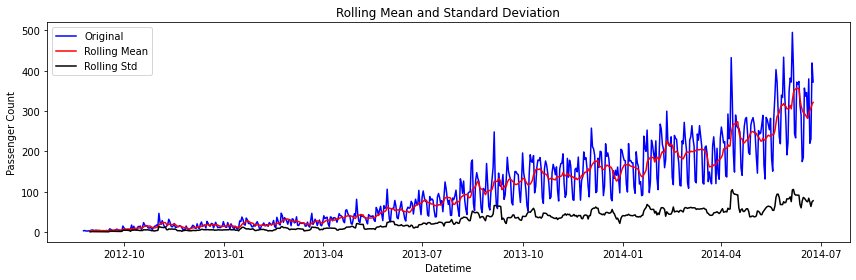

Results of Dickey-Fuller Test:
Test Statistic                   1.387308
P-Value                          0.997056
#Lags Used                      20.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In [27]:
# Creating a function to check stationarity of the given data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Passenger Count')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

As the test statistic is more than the critical values, we can say that the time series is non-stationary. We can also see an upward trend in the visualization, therefore, let us first remove the trend and seasonality from the data to make it stationary.

To remove an increasing trend, let us apply log transformation to penalize higher values more than lower values.

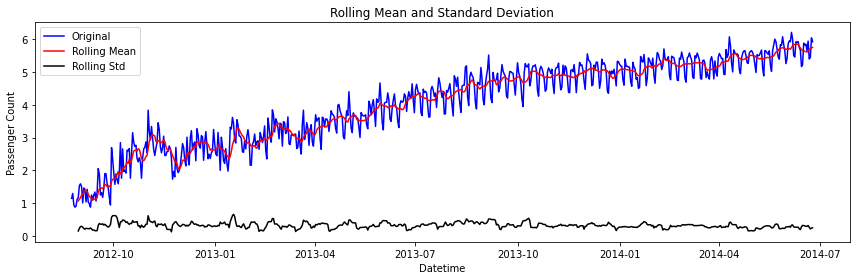

Results of Dickey-Fuller Test:
Test Statistic                  -2.405213
P-Value                          0.140270
#Lags Used                      20.000000
Number of Observations Used    648.000000
Critical Value (1%)             -3.440482
Critical Value (5%)             -2.866011
Critical Value (10%)            -2.569151
dtype: float64


In [28]:
# Performing log transformation to remove trend 
train_log = np.log(train)
check_stationarity(train_log)

Result shows increase in stationarity as p-value reduced considerably and test statistic is closer to the critical values than before. But, still it is non-stationary as p-value>0.05.

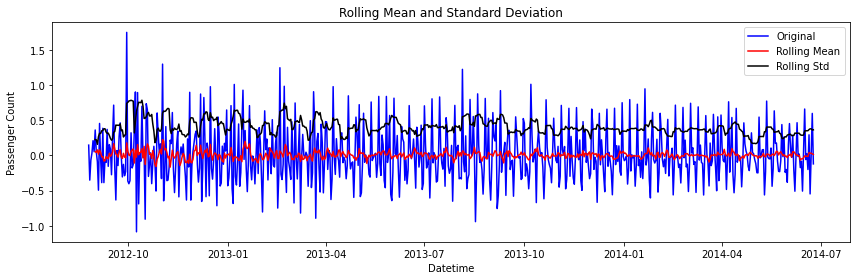

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
P-Value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [30]:
# First Differencing of log-transformed time series
train_log_diff = train_log - train_log.shift(1)
train_log_diff.dropna(inplace=True)
check_stationarity(train_log_diff)

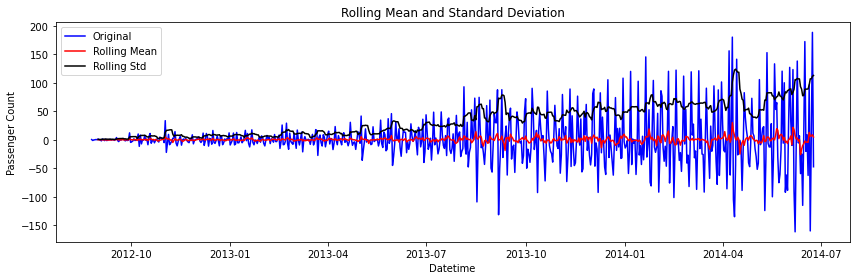

Results of Dickey-Fuller Test:
Test Statistic                -6.862102e+00
P-Value                        1.592824e-09
#Lags Used                     2.000000e+01
Number of Observations Used    6.470000e+02
Critical Value (1%)           -3.440498e+00
Critical Value (5%)           -2.866017e+00
Critical Value (10%)          -2.569154e+00
dtype: float64


In [31]:
# First differencing of the original training time series
train_diff = train - train.shift(1)
train_diff.dropna(inplace=True)
check_stationarity(train_diff)

The test statistic value is considerably less than critical value and p-value is also far less than 0.05 after first differencing on both original training time series and log-transformed training time series. Thus, we can say that both the series are stationary and value of parameter d is 1 for both. Let us proceed with both of them to reach the optimal solution.

Log-transformed training time series:


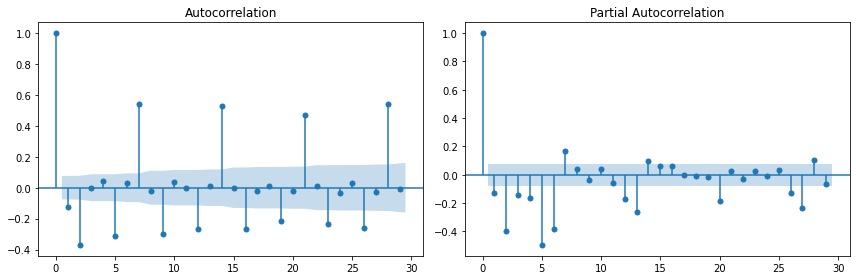

Original training time series:


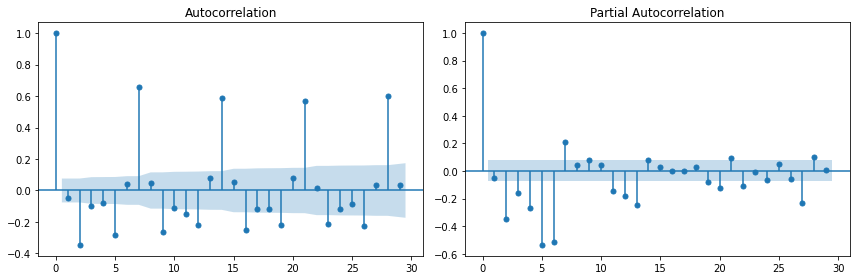

In [85]:
# Determining values of parameters p & q using pacf & acf plots resp.
print('Log-transformed training time series:')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_log_diff, ax=axes[0])
plot_pacf(train_log_diff, ax=axes[1])
plt.tight_layout()
plt.show()

print('Original training time series:')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_diff, ax=axes[0])
plot_pacf(train_diff, ax=axes[1])
plt.tight_layout()
plt.show()

Let us apply Auto-ARIMA model to identify most optimal parameters for ARIMA models on log-transformed and original training time series.

In [87]:
# Auto-ARIMA on log-transformed training time series
autoarima_log = auto_arima(train_log, d=1, m=7)
autoarima_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  669
Model:             SARIMAX(3, 1, 3)x(1, 0, [1], 7)   Log Likelihood                  -9.920
Date:                             Thu, 02 Dec 2021   AIC                             37.840
Time:                                     18:34:32   BIC                             78.378
Sample:                                          0   HQIC                            53.544
                                             - 669                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4180      0.081     -5.160      0.000      -0.577      -0.259
ar.L2         -0.5797      0.054    -10.831      0.000      -0.685      -0.475
ar.L3          0.3403      0.049      7.012      0.000       0.245       0.435
ma.L1         -0.0557      0.076     -0.734      0.463      -0.205       0.093
ma.L2          0.0981      0.066      1.489      0.136      -0.031       0.227
ma.L3         -0.7818      0.059    -13.283      0.000      -0.897      -0.666
ar.S.L7        0.9897      0.007    152.094      0.000       0.977       1.002
ma.S.L7       -0.8798      0.026    -33.868      0.000      -0.931      -0.829
sigma2         0.0596      0.002     29.251      0.000       0.056       0.064
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               560.98
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

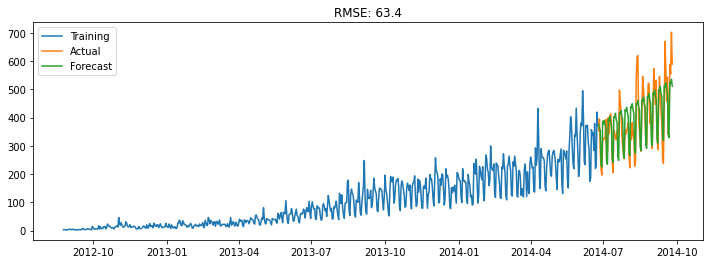

In [184]:
# Modeling and Forecasting
model_log = SARIMAX(train_log, order=(3, 1, 3), seasonal_order =(1, 0, 1, 7))
model_log = model_log.fit(disp=-1)
forecast = np.exp(model_log.forecast(len(valid)))
sarimax_log_rmse = mean_squared_error(valid, forecast, squared=False)

# Plotting the forecast
plt.figure(figsize=(12,4))
plt.plot(train, label='Training')
plt.plot(valid, label='Actual')
plt.plot(forecast, label='Forecast')
plt.title(f'RMSE: {round(sarimax_log_rmse, 2)}')
plt.legend(loc=2)
plt.show()

In [90]:
# Auto-ARIMA on original training time series
autoarima_orig = auto_arima(train, d=1, m=7)
autoarima_orig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  669
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -3042.300
Date:                                Thu, 02 Dec 2021   AIC                           6096.600
Time:                                        18:39:58   BIC                           6123.626
Sample:                                             0   HQIC                          6107.070
                                                - 669                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4458      0.029     15.606      0.000       0.390       0.502
ma.L1         -0.9647      0.010    -99.221      0.000      -0.984      -0.946
ar.S.L7        0.9955      0.005    216.493      0.000       0.987       1.005
ma.S.L7       -0.7653      0.027    -27.859      0.000      -0.819      -0.711
ma.S.L14      -0.0745      0.023     -3.307      0.001      -0.119      -0.030
sigma2       515.8513     13.141     39.254      0.000     490.095     541.608
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              8901.77
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              32.26   Skew:                             2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

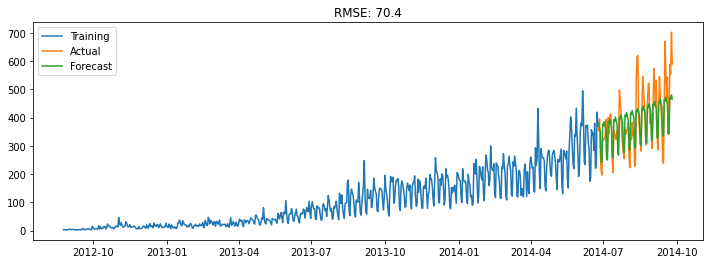

In [185]:
# Modeling and Forecasting
model_orig = SARIMAX(train, order=(1, 1, 1), seasonal_order =(1, 0, 1, 7))
model_orig = model_orig.fit(disp=-1)
forecast = model_orig.forecast(len(valid))
sarimax_orig_rmse = mean_squared_error(valid, forecast, squared=False)

# Plotting the forecast
plt.figure(figsize=(12,4))
plt.plot(train, label='Training')
plt.plot(valid, label='Actual')
plt.plot(forecast, label='Forecast')
plt.title(f'RMSE: {round(sarimax_orig_rmse, 2)}')
plt.legend(loc=2)
plt.show()

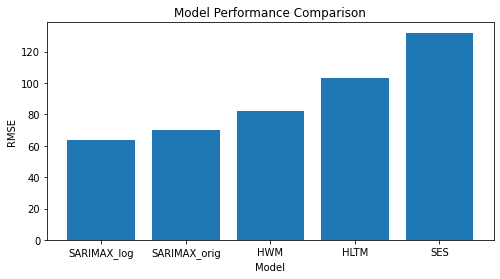

In [194]:
# Comparing Model Performances
perf = pd.DataFrame({'Model': ['SES', 'HLTM', 'HWM', 'SARIMAX_log', 'SARIMAX_orig'],
                     'RMSE': [ses_rmse, hltm_rmse, hwm_rmse, sarimax_log_rmse, sarimax_orig_rmse]})
perf.sort_values('RMSE', inplace=True)

# Plotting model performances
plt.figure(figsize=(8, 4))
plt.bar(perf.Model, perf.RMSE)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.show()

SARIMAX model on log-transformed training time series performed better than other models. Therefore, we will use it to forecast for the test data. 

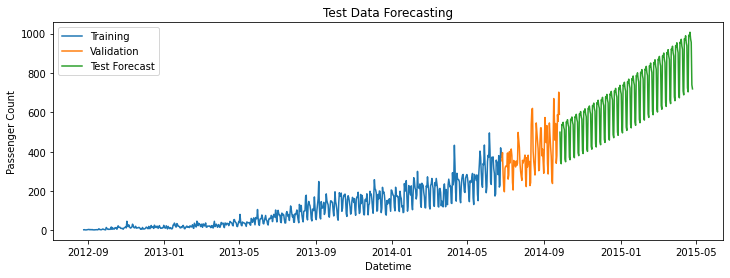

In [195]:
# Forecasting for test data
# forecast = hwm.predict(start='2014-09-26', end='2015-04-26') # 267.1
# forecast = model_orig.predict(start='2014-09-26', end='2015-04-26') # 216.1
forecast = np.exp(model_log.predict(start='2014-09-26', end='2015-04-26')) # 174.5

# Plotting the forecast
plt.figure(figsize=(12,4))
plt.plot(train, label='Training')
plt.plot(valid, label='Validation')
plt.plot(forecast, label='Test Forecast')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.title('Test Data Forecasting')
plt.legend(loc=2)
plt.show()

In [196]:
# Preparing forecast data for submission
fc = forecast.reset_index()
fc.columns = ['Datetime', 'Forecast']
fc['Year'] = fc.Datetime.dt.year
fc['Month'] = fc.Datetime.dt.month
fc['Day'] = fc.Datetime.dt.day
fc.head()

,Datetime,Forecast,Year,Month,Day
0,2014-09-26,498.906924,2014,9,26
1,2014-09-27,351.787984,2014,9,27
2,2014-09-28,338.735451,2014,9,28
3,2014-09-29,537.979727,2014,9,29
4,2014-09-30,533.994900,2014,9,30


In [197]:
# Preparing test data for submission
test = test_df.copy()
test['Datetime'] = pd.to_datetime(test['Datetime'], format='%d-%m-%Y %H:%M')
test['Year'] = test.Datetime.dt.year
test['Month'] = test.Datetime.dt.month
test['Day'] = test.Datetime.dt.day
test['Hour'] = test.Datetime.dt.hour
test.head()

,ID,Datetime,Year,Month,Day,Hour
0,18288,2014-09-26 00:00:00,2014,9,26,0
1,18289,2014-09-26 01:00:00,2014,9,26,1
2,18290,2014-09-26 02:00:00,2014,9,26,2
3,18291,2014-09-26 03:00:00,2014,9,26,3
4,18292,2014-09-26 04:00:00,2014,9,26,4


In [198]:
# Calculating hourly weightage
weights = hourly.reset_index()
weights['Hour'] = weights.Datetime.dt.hour
weights['Weight'] = weights['Count']/weights['Count'].sum()
weights = weights.groupby('Hour').Weight.sum().reset_index()
weights.head()

,Hour,Weight
0,0,0.044287
1,1,0.035343
2,2,0.029911
3,3,0.024714
4,4,0.020802


In [199]:
# Transforming daily predictions to hourly basis
forecast_df = pd.merge(test, fc, on=['Year', 'Month', 'Day'], how='left')
forecast_df = pd.merge(forecast_df, weights, on='Hour', how='left')
forecast_df['Count'] = forecast_df['Forecast']*24*forecast_df['Weight']
submission = forecast_df[['ID', 'Count']]
print(submission.shape)
submission.head()

(5112, 2)


,ID,Count
0,18288,530.277247
1,18289,423.188986
2,18290,358.148228
3,18291,295.925085
4,18292,249.081039


In [200]:
# Submitting predictions
submission.to_csv('Submission model_log.csv', index=False)